In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
import statsmodels.api as sm
import numpy as np

In [2]:
# read data
gdp_data_path = '/carnegie/data/Shared/Labs/Caldeira Lab/Everyone/'

gdp = pd.read_csv(os.path.join(gdp_data_path, 'gdp_pop_energy_data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_5447781.csv'), header=2)
# Source for GDP: https://data.worldbank.org/


exp_temp_data_path = '/carnegie/data/Shared/Labs/Caldeira Lab/Everyone/exp_temperature_data/'

cdd_18 = pd.read_excel(os.path.join(exp_temp_data_path, 'Enhanced-Degree-Days-Database-March-2015.xlsx'), sheet_name='t2m.cdd.18C')
hdd_18 = pd.read_excel(os.path.join(exp_temp_data_path, 'Enhanced-Degree-Days-Database-March-2015.xlsx'), sheet_name='T2m.hdd.18C')
# Source for CDD and HDD: https://www.kapsarc.org/research/projects/global-degree-days-database/

frac_people_aggr = pd.read_csv(os.path.join(exp_temp_data_path, 'GDP-vs-agriculture-employment.csv'))
# Source https://ourworldindata.org/grapher/GDP-vs-agriculture-employment

cdd_18_alt = nc.Dataset(os.path.join(exp_temp_data_path, 'CDD_netcdf/gldas_0p25_deg_cdd_base_T_18C_1970_2018_ann.nc4'))
# Source: https://doi.pangaea.de/10.1594/PANGAEA.903123

In [3]:
# preprocess data

# Rearrange GDP data
gdp = gdp.set_index('Country Name')
gdp = gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
gdp = gdp.stack()
gdp = gdp.reset_index()
gdp.columns = ['Country Name', 'Year', 'GDP']
# Year column is string, convert to int
gdp['Year'] = gdp['Year'].astype(int)
gdp = gdp.set_index(['Country Name', 'Year'])
gdp_world = gdp.loc['World']
# print("GDP world")
# print (gdp_world)

# Rearrange DD data
def rearrange_dd(dd_df, var='CDD'):
    dd_df = dd_df.set_index('Country')
    # Drop rows after Zimbabwe
    dd_df = dd_df.drop(dd_df.index[range(dd_df.index.get_loc('Mean')+1, len(dd_df))])
    #Drop columns that are not years
    dd_df = dd_df.drop(columns=['6 hrs AVERAGE  1964-2013', 'Daily AVERAGE 1964-2013'])
    dd_df = dd_df.stack()
    dd_df = dd_df.reset_index()
    dd_df.columns = ['Country Name', 'Year', var]
    # Convert from 6h to daily frequency
    dd_df[var] = dd_df[var]/4.
    dd_df = dd_df.set_index(['Country Name', 'Year'])
    return dd_df

cdd = rearrange_dd(cdd_18, var='CDD')
cdd_world = cdd.loc['Mean']
hdd = rearrange_dd(hdd_18, var='HDD')
hdd_world = hdd.loc['Mean']
# print("CDD world")
# print (cdd_world)

# Rearrange frac_people_aggr data
frac_people_aggr = frac_people_aggr.set_index(['Entity', 'Year'])
frac_people_aggr = frac_people_aggr['share_employed_agri']
frac_people_aggr_world = frac_people_aggr.loc['World']
# print(frac_people_aggr_world)

# combine data sources
df = pd.concat([gdp_world, cdd_world], axis=1)
df = pd.concat([df, hdd_world], axis=1)
df = pd.concat([df, frac_people_aggr_world], axis=1)
df.dropna(inplace=True)
print(df)

               GDP          CDD          HDD  share_employed_agri
Year                                                             
1991   4414.827055  1457.037175  1684.002467            43.699088
1992   4645.154492  1415.157092  1694.813929            43.474452
1993   4647.739027  1414.446071  1721.156176            42.761867
1994   4940.824175  1440.391394  1642.699128            42.020773
1995   5421.595373  1447.145813  1648.473829            41.115858
1996   5461.773588  1417.331155  1756.211290            40.451693
1997   5364.200785  1444.812071  1651.410798            40.078907
1998   5275.568758  1552.592089  1610.430968            40.052120
1999   5401.497858  1458.211088  1616.928488            40.067430
2000   5507.448927  1457.911885  1629.129194            39.910355
2001   5400.263499  1483.331889  1640.444919            39.570068
2002   5535.408911  1500.754220  1592.917318            39.347629
2003   6127.699308  1523.263606  1681.526924            38.871089
2004   681

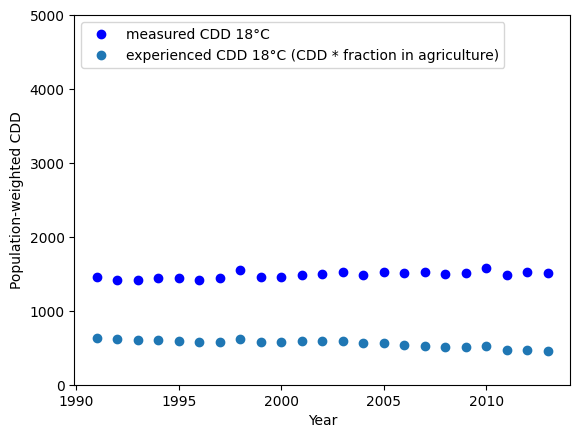

In [8]:
# plot
fig, ax = plt.subplots()
# Year vs GDP
ax.plot(df.index.get_level_values('Year'), df['CDD'], color='b', marker='o', linestyle='None', label='measured CDD 18°C')
# ax.plot(df.index.get_level_values('Year'), df['HDD'], color='r', marker='o', linestyle='None', label='measured HDD 18°C')
ax.plot(df.index.get_level_values('Year'), df['CDD']*df['share_employed_agri']/100., color='tab:blue', marker='o', linestyle='None', label='experienced CDD 18°C (CDD * fraction in agriculture)')
# ax.plot(df.index.get_level_values('Year'), df['HDD']*df['share_employed_agri']/100., color='tab:red', marker='o', linestyle='None', label='experienced HDD 18°C')
ax.set_xlabel('Year')
ax.set_ylabel('Population-weighted CDD')
# ax.set_xlim([1980, 2013])
ax.set_ylim([0, 5000.])


# Legend at upper right inside plot
ax.legend(loc='upper left', bbox_to_anchor=(0., 1.0))
plt.savefig('experienced_CDD.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_242022/566967911.py:20: RuntimeWarning: divide by zero encountered in power
  return a * x**(-0.75)


Text(0.65, 0.95, 'f(x) = 85 * x^(-0.75)')

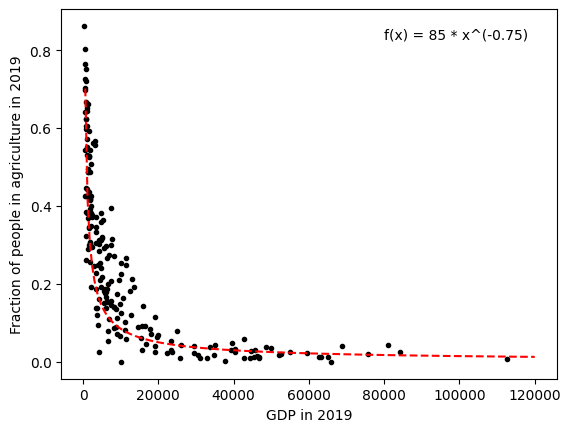

In [28]:
# GDP of all countries in 2021
gdp_2019 = gdp[gdp.index.get_level_values('Year') == 2019]
frac_people_aggr_2019 = frac_people_aggr[frac_people_aggr.index.get_level_values('Year') == 2019]

df_2019 = pd.concat([gdp_2019, frac_people_aggr_2019], axis=1)
df_2019.dropna(inplace=True)
# Add a point for GDP = 0
# df_2019.loc['Zero'] = [0, 100]
df_2019['share_employed_agri'] = df_2019['share_employed_agri']/100.

# Plot GDP vs fraction of people in agriculture
fig, ax = plt.subplots()
ax.plot(df_2019['GDP'], df_2019['share_employed_agri'], color='k', marker='o', markersize=3, linestyle='None')
ax.set_xlabel('GDP in 2019')
ax.set_ylabel('Fraction of people in agriculture in 2019')

# Fit function
from scipy.optimize import curve_fit
def func(x, a):
    return a * x**(-0.75)

# Fit function to data
popt, pcov = curve_fit(func, df_2019['GDP'], df_2019['share_employed_agri'])
plot_x = np.linspace(0, 1.2e5, 200)
ax.plot(plot_x, func(plot_x, *popt), color='r', linestyle='--')

# Print fit function on plot
ax.text(0.65, 0.95, 'f(x) = {:.0f} * x^(-0.75)'.format(popt[0]), transform=ax.transAxes, fontsize=10, verticalalignment='top')

# model = sm.OLS(df_2019['share_employed_agri'], df_2019['GDP'])
# result = model.fit()
# print(result.summary())
# print(result.params)
# ax.plot(df_2019['GDP'], result.fittedvalues, color='r', linestyle='--')